In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/CT_Scan.zip" -d "/content/sample_data/Dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/Dataset/__MACOSX/CT_Scan/LungCT-Diagnosis/R_150/10-29-1997-Diagnostic Pre-Surgery Contrast Enhanced CT-48002/._2.000000- NONE -72790  
  inflating: /content/sample_data/Dataset/__MACOSX/CT_Scan/LungCT-Diagnosis/R_150/._10-29-1997-Diagnostic Pre-Surgery Contrast Enhanced CT-48002  
  inflating: /content/sample_data/Dataset/__MACOSX/CT_Scan/LungCT-Diagnosis/._R_150  
   creating: /content/sample_data/Dataset/CT_Scan/LungCT-Diagnosis/R_168/
   creating: /content/sample_data/Dataset/CT_Scan/LungCT-Diagnosis/R_168/09-19-1998-Diagnostic Pre-Surgery Contrast Enhanced CT-72187/
   creating: /content/sample_data/Dataset/CT_Scan/LungCT-Diagnosis/R_168/09-19-1998-Diagnostic Pre-Surgery Contrast Enhanced CT-72187/2.000000- NONE -44851/
  inflating: /content/sample_data/Dataset/CT_Scan/LungCT-Diagnosis/R_168/09-19-1998-Diagnostic Pre-Surgery Contrast Enhanced CT-72187/2.000000- NONE -44851/1-42.dcm  
   creating: /

In [3]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d, Module, Softmax, BatchNorm1d, Dropout, Tanh
from torch.optim import Adam, SGD
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from random import shuffle
import matplotlib.pyplot as plt
!pip install pydicom
import pydicom
from pydicom.data import get_testdata_files
import os
import numpy as np
import time

     |████████████████████████████████| 1.9MB 12.1MB/s 


In [4]:
#to run the code change the path to your data path
def find_all_path(head_path = "/content/sample_data/Dataset/CT_Scan/LungCT-Diagnosis/"):
    array_pepole_ct = os.listdir(head_path)
    print("number of sample: ", len(array_pepole_ct))
    dic_files_DCM = {}
    for file_name in array_pepole_ct:
        f1 =  os.listdir(head_path+file_name)[0]
        f2 =  os.listdir(head_path+file_name+"/"+f1)[0]
        path = head_path+file_name+"/"+f1+"/"+f2
        temp = []
        for dirName, subdirList, fileList in os.walk(path):
            for filename in fileList:
                if ".dcm" in filename.lower(): 
                    temp.append(os.path.join(dirName,filename))
  
    dic_files_DCM[file_name] = temp

    return dic_files_DCM

def load_sample_pixel(sample_path):

    ct_scan = pydicom.read_file(sample_path[0])
    ConstPixelDims = (int(ct_scan.Rows), int(ct_scan.Columns), len(sample_path))
    array_dicom = np.zeros(ConstPixelDims, dtype=ct_scan.pixel_array.dtype)
  
    array_dicom_file = [pydicom.read_file(i) for i in sample_path]
    array_dicom_file.sort(key = lambda x: int(x.InstanceNumber))  
    for n, ct_scan in enumerate(array_dicom_file):  
    array_dicom[:,:,n] = ct_scan.pixel_array
  
    return array_dicom


t1 = time.time()
all_sample_dicom = find_all_path()
all_sample_dicom_pixel = {}

for j in list(all_sample_dicom):
    patient_id = j.replace("R","Patient")
    array_dicom = load_sample_pixel(all_sample_dicom[j])
    all_sample_dicom_pixel[patient_id] = array_dicom

t2 = time.time()
print(t2 - t1)


number of sample:  61
26.000219583511353


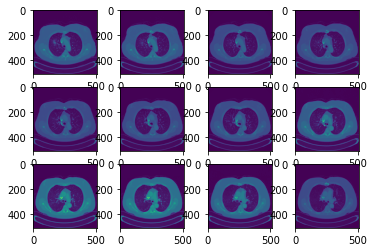

In [5]:
import cv2

fig = plt.figure()
list_dicom  = []
for n, _ in  enumerate(all_sample_dicom_pixel["Patient_069"]):
    list_dicom.append(np.array(all_sample_dicom_pixel["Patient_069"][:,:,n+25]))
    if n >= 11:
        break

IMG_PX_SIZE =  512
for num,each_slice in enumerate(list_dicom):
    y = fig.add_subplot(3,4,num+1)
    new_img = cv2.resize(np.array(each_slice),(IMG_PX_SIZE,IMG_PX_SIZE))
    y.imshow(new_img)
plt.show()

In [6]:
import math
from scipy import ndimage

def chunks(l, n):
    list_ = []
    for i in range(0, l.shape[2], n):
        list_.append(l[:,:,i:i + n])
    return list_

def mean(images):
    return np.sum(images,axis = 2)/images.shape[2]

IMG_PX_SIZE = 256

def resize_images(all_sample_dicom_pixel, ch_size):
    ConstPixelDims = (IMG_PX_SIZE, IMG_PX_SIZE, ch_size)
    array_dicom = np.zeros(ConstPixelDims)
    resized_image = {}
    for i in all_sample_dicom_pixel:
        image = cv2.resize(np.array(all_sample_dicom_pixel[i]),(IMG_PX_SIZE,IMG_PX_SIZE))
        chunk = chunks(image,math.ceil(image.shape[2]/ch_size))
    for n,j in enumerate(chunk):
        array_dicom[:,:,n] = mean(j)
    if array_dicom.shape[2] < ch_size:
        array_dicom[:,:,len(chunk):] = image[:,:,-(ch_size-len(chunk)):]

    resized_image[i] = array_dicom
  
    return resized_image

def normalize(img):
    min = -1000
    max = 400
    img[img < min] = min
    img[img > max] = max
    img = (img - min) / (max - min)
    normalized = img.astype("float32")
  
    return normalized

def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

resized_img = {}
for n, j in enumerate(list(all_sample_dicom_pixel)):
    # normalized = normalize(np.array(all_sample_dicom_pixel[j]))  
    resized_array_dicom = resize_volume(np.array(all_sample_dicom_pixel[j]))
    resized_img[j] = resized_array_dicom
  

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import sklearn
import tensorflow as tf


@tf.function
def rotate(volume, angle):
  
    def scipy_rotate(volume, angle):
        volume = ndimage.rotate(volume, angle, reshape=False)
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume, angle], tf.float32)
    return augmented_volume


def agumentation(X_train, y_train, repeat = 3):

    new_X_train = [tf.expand_dims(img.astype(np.float32), axis=3) for img in X_train]
    new_y_train = [label for label in y_train]

    for img,label in zip(X_train,y_train):
        angles = [-20, -15, -10, -5, 5, 10, 15, 20]
        for j in range(repeat):
            angle = random.choice(angles)
            img_r = rotate(img.astype(np.float32), angle)
            img_new = tf.expand_dims(img_r, axis=3)
            new_X_train.append(img_new)
            new_y_train.append(label)
            angles.remove(angle)

    new_y_train = np.array(new_y_train)
    return new_X_train, new_y_train


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def get_model(width=128, height=128, depth=24):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    # x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", name = "conv1")(inputs)
    # x = layers.MaxPool3D(pool_size=2)(x)
    # x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", name = "conv2")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", name = "conv3")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu", name = "conv4")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    # x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=2, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model



def get_model_2D(width=128, height=128):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, 1))

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", name = "conv1")(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=32, kernel_size=5, activation="relu", name = "conv2")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=64, kernel_size=7, activation="relu", name = "conv3")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=128, kernel_size=7, activation="relu", name = "conv4")(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(units=2, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model_2D(width=128, height=128)
model.summary()


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
conv2 (Conv2D)               (None, 59, 59, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 32)        128   

In [11]:
#to run the code change the path to your label path
labels = pd.read_csv("/content/sample_data/label.txt", sep = '\t', header = None)
labels.columns = ["patient_id","status"]

p_id = [i for i in labels["patient_id"] if i != "Patient_260"]
p_status = [i for i in labels["status"]]

X = np.array([resized_img[i] for i in p_id])
y = np.array([int(j.split(" ")[0]) for i, j in zip(p_id, p_status)])

print(len(X), len(y))

X_2D = np.array([j[:,:,i] for j in X for i in range(64)])
y_2D = np.array([y[j] for j in range(len(y)) for i in range(64)])
print(len(X_2D),len(y_2D))


61 61
3904 3904


In [13]:
from sklearn.model_selection import StratifiedKFold


initial_learning_rate = 0.0001
epochs = 20
batch_size = 32
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
cvscores = []
best_model = get_model(width=128, height=128, depth=64)  
best_score = -343434
loss_train = []
loss_val = []
acc_train = []
acc_val = []
x = 0
best_model_num = 0
for train, test in kfold.split(X_2D, y_2D):
    x+=1
    # X_train, y_train = agumentation(X_2D[train], y_2D[train])
    X_train, y_train = sklearn.utils.shuffle(X_2D[train], y_2D[train])
    y_train = np.array([[1,0] if i == 0 else [0,1] for i in y_train])

    train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train.astype(np.float32)))
    train_dataset = (train_loader.shuffle(len(X_train)).batch(batch_size).prefetch(2))
    # model = get_model(width=128, height=128, depth=64)  # for 3D model
    model = get_model_2D(width=128, height=128)
    model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["acc"],)
    history = model.fit(train_dataset, epochs=epochs, shuffle=True, verbose=2)
    loss_train.append(history.history['loss'])
    acc_train.append(history.history['acc'])

    y_test = np.array([[1,0] if i == 0 else [0,1] for i in y_2D[test]])
    test_loader = tf.data.Dataset.from_tensor_slices((X_2D[test], y_test))
    test_dataset = (test_loader.shuffle(len(X_2D[test])).batch(batch_size).prefetch(2))
    scores = model.evaluate(test_dataset, verbose=0)
    if scores[1] * 100 > best_score:
        best_score = scores[1] * 100
        best_model = model
        best_model_num = x
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    acc_val.append(scores[1]*100)

    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("best score: ^^",best_score)

Epoch 1/20
98/98 - 2s - loss: 0.6626 - acc: 0.5911
Epoch 2/20
98/98 - 2s - loss: 0.6208 - acc: 0.6378
Epoch 3/20
98/98 - 2s - loss: 0.5777 - acc: 0.6846
Epoch 4/20
98/98 - 2s - loss: 0.5353 - acc: 0.7217
Epoch 5/20
98/98 - 2s - loss: 0.4847 - acc: 0.7531
Epoch 6/20
98/98 - 2s - loss: 0.4285 - acc: 0.8028
Epoch 7/20
98/98 - 2s - loss: 0.3701 - acc: 0.8297
Epoch 8/20
98/98 - 2s - loss: 0.2914 - acc: 0.8703
Epoch 9/20
98/98 - 2s - loss: 0.2475 - acc: 0.8915
Epoch 10/20
98/98 - 2s - loss: 0.1642 - acc: 0.9395
Epoch 11/20
98/98 - 2s - loss: 0.1317 - acc: 0.9491
Epoch 12/20
98/98 - 2s - loss: 0.1255 - acc: 0.9555
Epoch 13/20
98/98 - 2s - loss: 0.0904 - acc: 0.9677
Epoch 14/20
98/98 - 2s - loss: 0.0885 - acc: 0.9670
Epoch 15/20
98/98 - 2s - loss: 0.0559 - acc: 0.9808
Epoch 16/20
98/98 - 2s - loss: 0.0439 - acc: 0.9846
Epoch 17/20
98/98 - 2s - loss: 0.0429 - acc: 0.9859
Epoch 18/20
98/98 - 2s - loss: 0.0362 - acc: 0.9875
Epoch 19/20
98/98 - 2s - loss: 0.0288 - acc: 0.9914
Epoch 20/20
98/98 - 2

In [18]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_2D, y_2D, test_size=0.2, random_state=42)
y_train = np.array([[1,0] if i == 0 else [0,1] for i in y_train])
print(len(X_train), len(X_test))
model = get_model_2D(width=128, height=128)
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["acc"],)
history = model.fit(X_train, y_train, epochs=20, shuffle=True, verbose=2)
pred = model.predict(X_test)
pred = [np.argmax(i)for i in pred]
acc = 0
for i, j in zip(y_test, pred):
    if i == j :
        acc+=1
print("acc: ", acc/ len(y_test))
print("f1_score: ",f1_score(y_test, pred))



3123 781
Epoch 1/20
98/98 - 2s - loss: 0.6615 - acc: 0.6033
Epoch 2/20
98/98 - 2s - loss: 0.6080 - acc: 0.6366
Epoch 3/20
98/98 - 2s - loss: 0.5652 - acc: 0.6833
Epoch 4/20
98/98 - 2s - loss: 0.5297 - acc: 0.7217
Epoch 5/20
98/98 - 2s - loss: 0.4735 - acc: 0.7496
Epoch 6/20
98/98 - 2s - loss: 0.4221 - acc: 0.7855
Epoch 7/20
98/98 - 2s - loss: 0.3634 - acc: 0.8248
Epoch 8/20
98/98 - 2s - loss: 0.2857 - acc: 0.8738
Epoch 9/20
98/98 - 2s - loss: 0.1981 - acc: 0.9190
Epoch 10/20
98/98 - 2s - loss: 0.1737 - acc: 0.9318
Epoch 11/20
98/98 - 2s - loss: 0.1212 - acc: 0.9542
Epoch 12/20
98/98 - 2s - loss: 0.1056 - acc: 0.9571
Epoch 13/20
98/98 - 2s - loss: 0.0686 - acc: 0.9760
Epoch 14/20
98/98 - 2s - loss: 0.0629 - acc: 0.9747
Epoch 15/20
98/98 - 2s - loss: 0.0557 - acc: 0.9817
Epoch 16/20
98/98 - 2s - loss: 0.0286 - acc: 0.9920
Epoch 17/20
98/98 - 2s - loss: 0.0365 - acc: 0.9872
Epoch 18/20
98/98 - 2s - loss: 0.0302 - acc: 0.9904
Epoch 19/20
98/98 - 2s - loss: 0.0345 - acc: 0.9882
Epoch 20/20


2


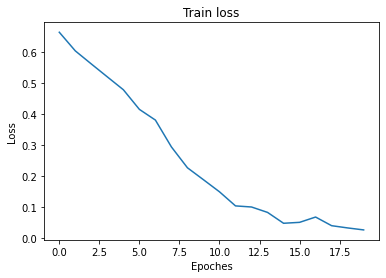

In [16]:
loss_train.append(history.history['loss'])
acc_train.append(history.history['acc'])
plt.plot([i for i in range(20)],loss_train[2])
print(best_model_num)
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.title("Train loss")
plt.show()


In [63]:
from keras import backend as K

def visualize_class_activation_map(model, img):
        img = np.array([np.transpose(np.float32(img), (0, 1))])
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = model.get_layer('conv4')
        
        get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
        # print(np.array([img]).shape)
        new_img = np.array([img])
        # print(new_img.shape)
        new_img = new_img.reshape((1, 128, 128,1))
        # print("input shape:",new_img.shape)
        [conv_outputs, predictions] = get_output(new_img)
        # print("conv output shape:", conv_outputs.shape)
        # print("k",predictions)
        conv_outputs = conv_outputs[0,:, :, :] 
        # print(conv_outputs.shape)
        # print("conv output shape:", conv_outputs.shape)
        
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[:-1])
        # print("cam shape",cam.shape)
        target_class = 1
        # print(class_weights.shape)
        # print(class_weights[:,1])
        for i, w in enumerate(class_weights[:,np.argmax(predictions[0])]):
          # print(cam.shape)
          # print(w.shape)
          # print(conv_outputs.shape)
          # if i >= 12:
            # break  
            cam = abs(w) * conv_outputs[:,:,i] + cam
            return cam

# print(cam)


cam :  (17, 17)


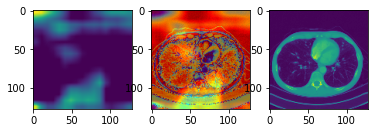

In [64]:
from skimage import exposure 
import cv2

input = X_2D[100]
cam = visualize_class_activation_map(model, input)
print("cam : ",cam.shape)

# heatmap = np.mean(cam, axis=-1)
heatmap = np.maximum(cam, 0)
heatmap /= np.max(heatmap)
# plt.imshow(heatmap)
# plt.show()

heatmap = cv2.resize(heatmap, (128, 128))
img_first = input
u8 = img_first.astype(np.uint8)
img = cv2.applyColorMap(u8, cv2.COLORMAP_JET)
map_img = exposure.rescale_intensity(heatmap, out_range=(0, 255))
map_img = np.uint8(map_img)
heatmap_img = cv2.applyColorMap(map_img, cv2.COLORMAP_JET)
fin = cv2.addWeighted(heatmap_img, 0.5, img, 0.5, 0)

l  = []
l.append(heatmap)
l.append(fin)
l.append(input)
fig = plt.figure()
for num,each_slice in enumerate(l):
  y = fig.add_subplot(1,3,num+1)
  y.imshow(each_slice)
plt.show()


In [ ]:
d